In [2]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [10]:
def make_pipeline():
    
    #treasury_stock = Fundamentals_m.treasury_stock.latest # Desperate
    #treasury_stock = treasury_stock.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    basic_accounting_change_earnings_reports_mask = Fundamentals_m.basic_accounting_change_earnings_reports.latest # Desperate
    basic_accounting_change_earnings_reports_mask = basic_accounting_change_earnings_reports_mask.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    universe = QTradableStocksUS()
    
    combined_factor = (
        #treasury_stock
        basic_accounting_change_earnings_reports_mask
        
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.014,0.024,0.026
IC Std.,0.059,0.063,0.065
Risk-Adjusted IC,0.234,0.386,0.406
t-stat(IC),2.281,3.761,3.958
p-value(IC),0.025,0.000,0.000
IC Skew,-0.343,-1.073,-0.982
IC Kurtosis,-0.444,1.901,0.769


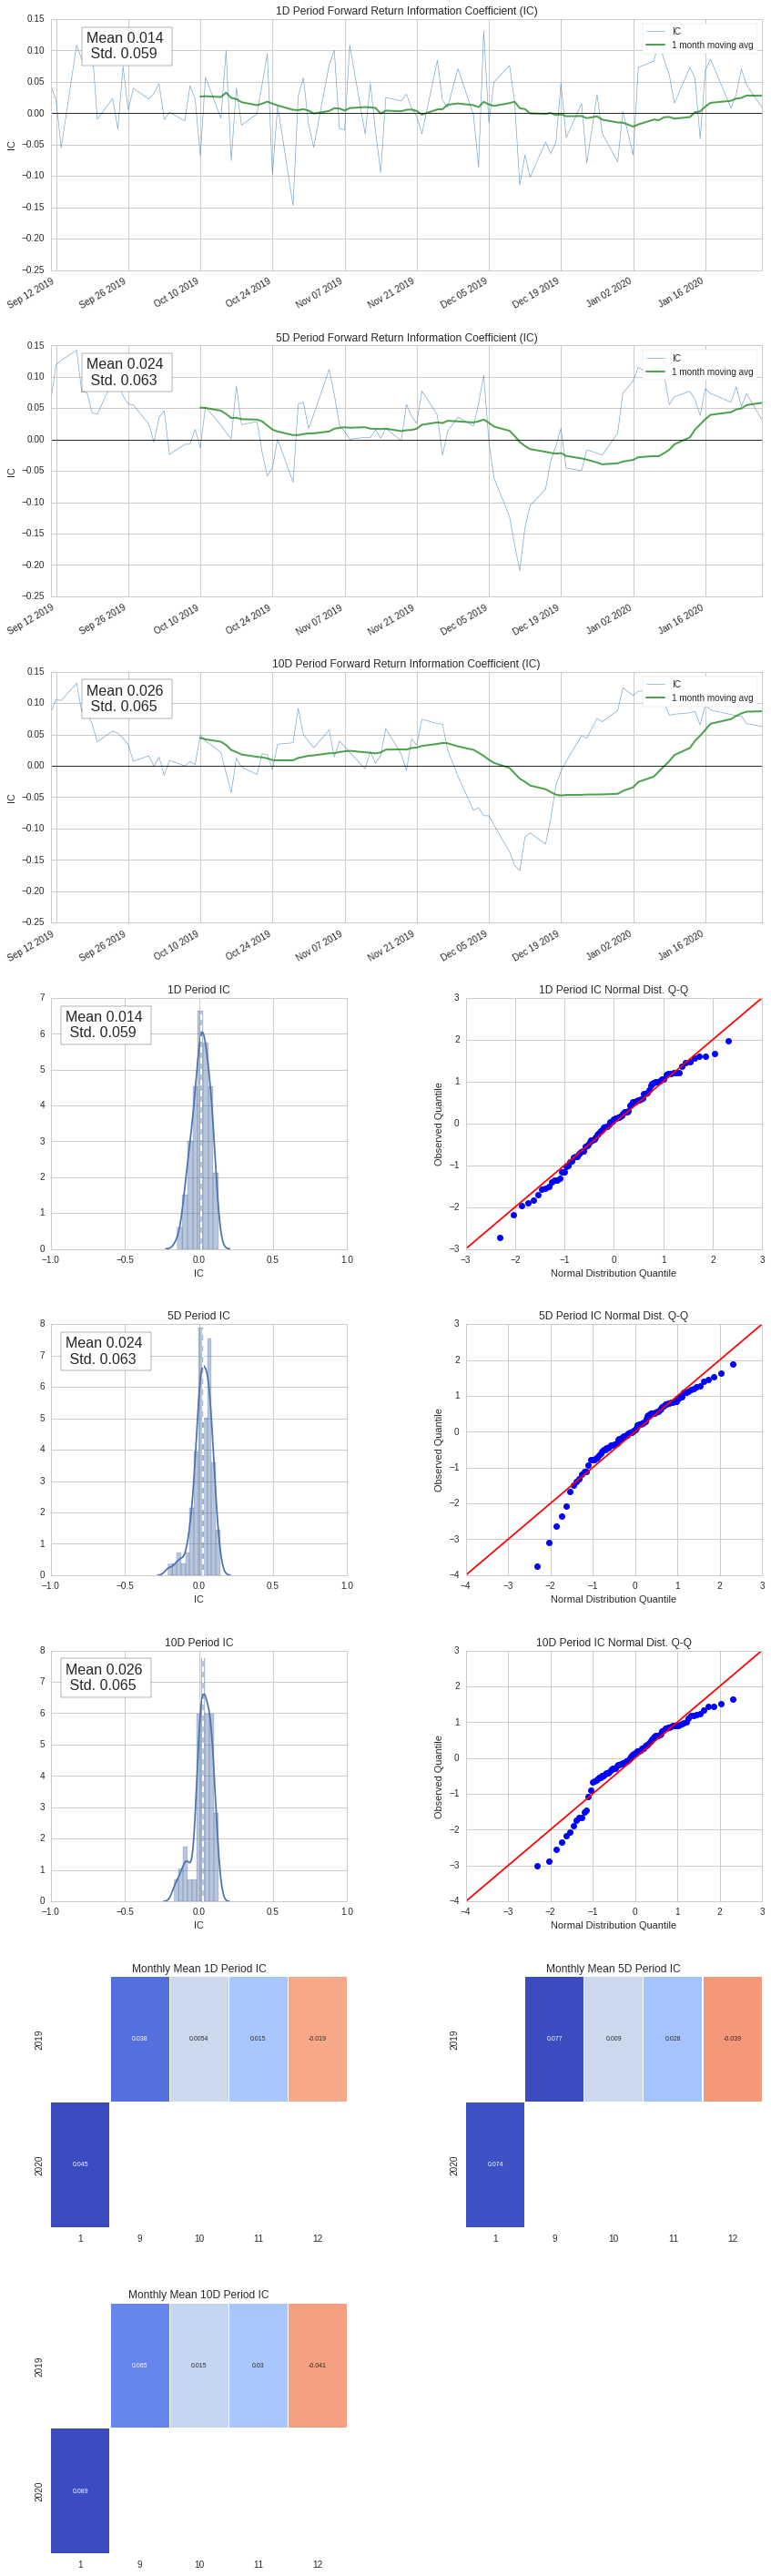

In [11]:
today = "2/11/2020"
six_months_before="9/11/2019"
two_years ="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= six_months_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=six_months_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.004,0.006,0.010
IC Std.,0.050,0.054,0.055
Risk-Adjusted IC,0.073,0.109,0.175
t-stat(IC),1.614,2.421,3.892
p-value(IC),0.107,0.016,0.000
IC Skew,-0.024,-0.308,-0.374
IC Kurtosis,-0.161,0.425,0.358


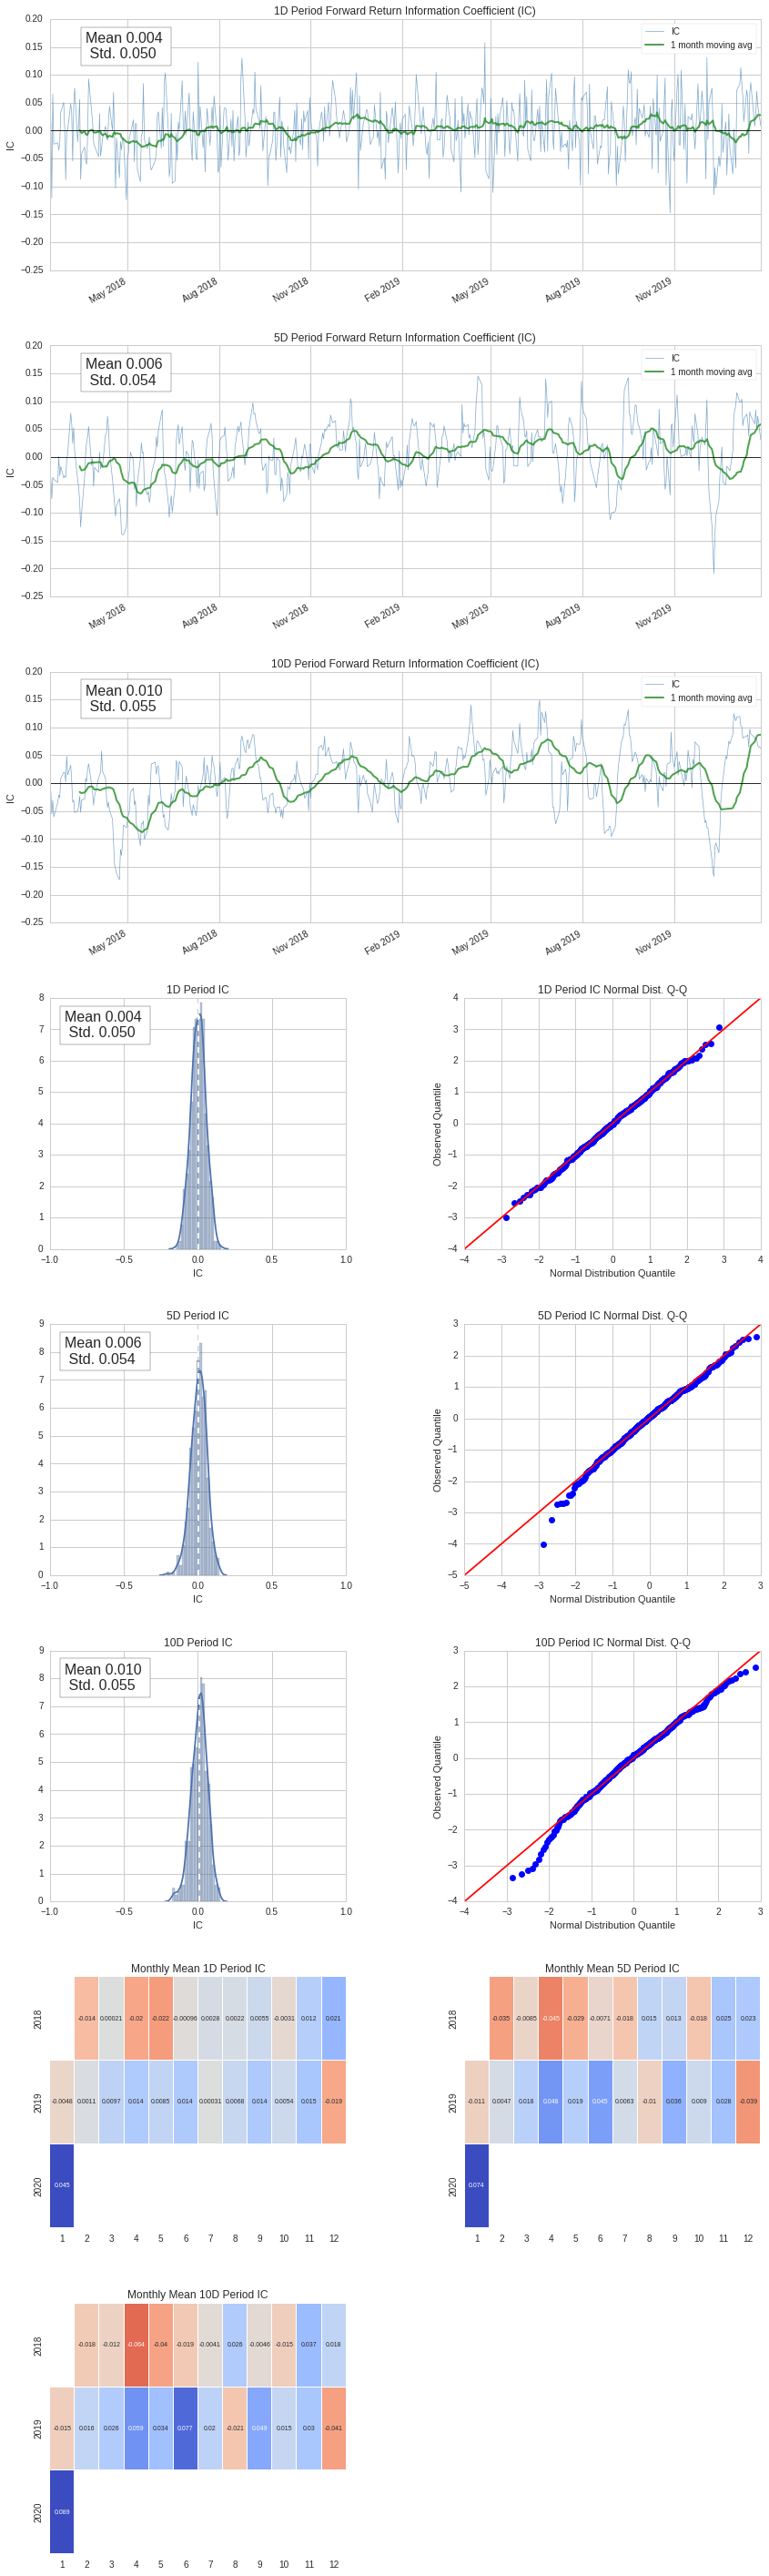

In [12]:

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.011,0.013,0.016
beta,-0.027,-0.031,-0.040
Mean Period Wise Return Top Quantile (bps),1.194,1.174,1.079
Mean Period Wise Return Bottom Quantile (bps),-0.277,-0.272,-0.251
Mean Period Wise Spread (bps),1.471,1.421,1.301


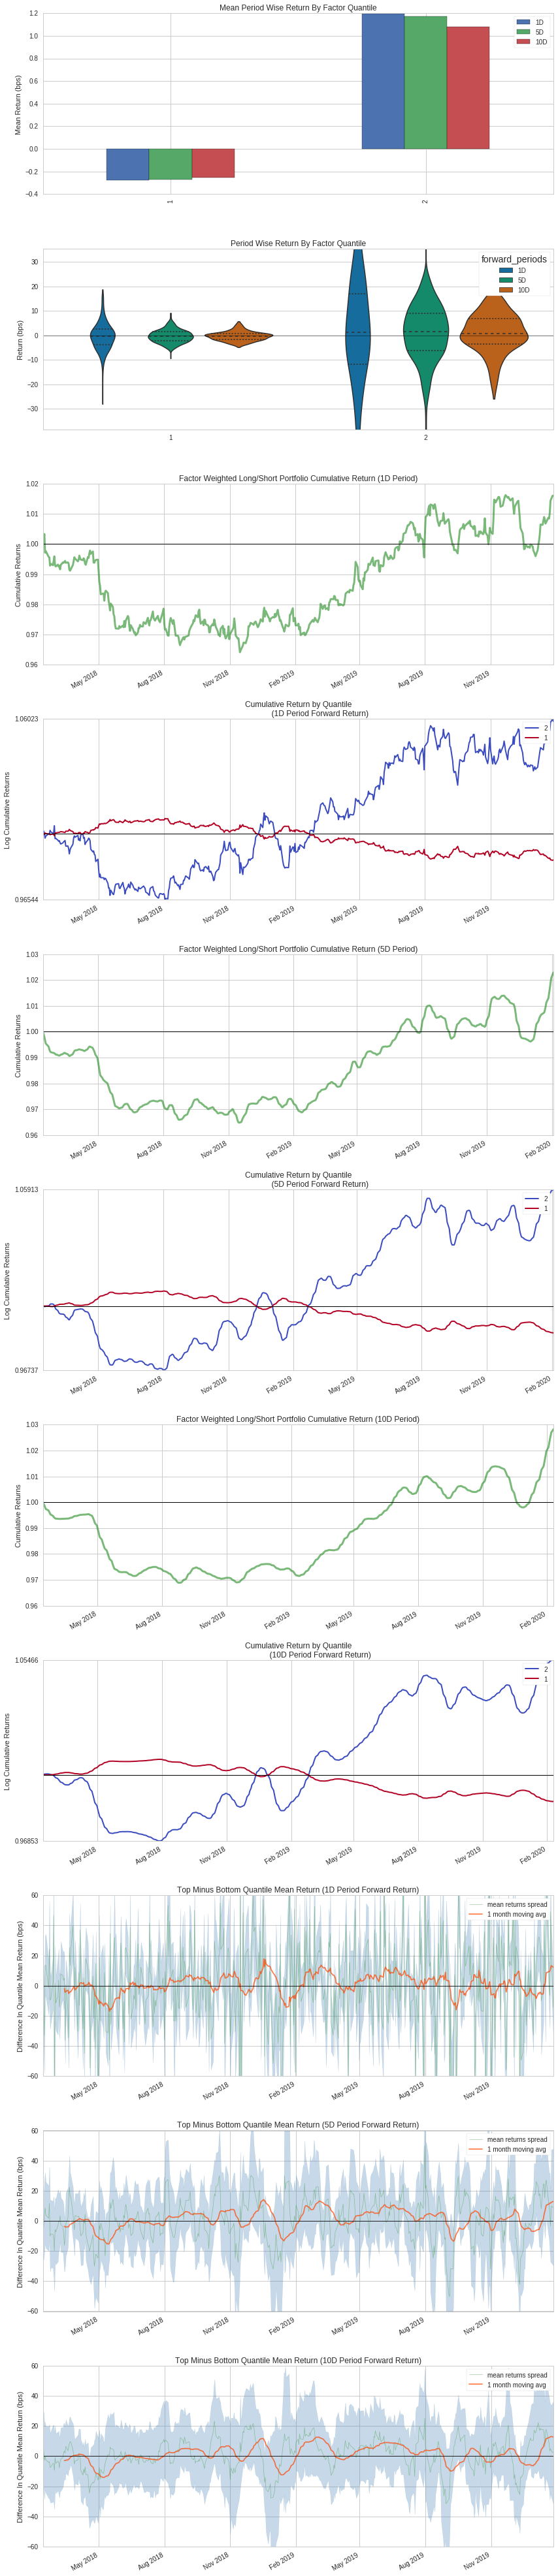

In [13]:
create_returns_tear_sheet(factor_data)